<a href="https://colab.research.google.com/github/reve-0212/Data-Analysis-with-Open-Source/blob/main/%EC%98%A4%ED%94%88%EC%86%8C%EC%8A%A4_%EB%8D%B0%EC%9D%B4%ED%84%B0_%EB%B6%84%EC%84%9D_14%EA%B0%95.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 14강 비정형 데이터 분석 : 패션 사진 데이터 활용

### 목표

- 비정형 데이터를 인공지능 모델로 분석하여 실무에서 활용 가능한 보고서 형태로 가공

- 패션 트렌드라는 구체적인 주제를 통해, 비정형 데이터 분석의 실질적인 활용 방안을 경험하고자 함


### 분석 프로세스 개요

1. 데이터 수집
  - requests를 이용한 RSS 데이터 수집
  - lxml을 이용한 XML 파싱
  - 이미지 데이터 추출
2. VLM을 이용한 이미지 분석
  - 프롬프트를 이용한 이미지 필터링
  - 프롬프트를 이용한 스타일 분석
3. LLM을 이용한 키워드 분석 및 보고서 작성
  - 텍스트 전처리
  - 색상 및 스타일 키워드 추출
  - 워드 클라우드 분석
  - 보고서 작성

# 주의 : 런타임 GPU 로 설정 필요

In [1]:
# 4bit VLM 처리를 위한 bitsandbytes 설치
# LLM 처리를 위한 VLLM 설치 (오래걸리는 작업(>5분)이므로 미리 실행!)
!pip install bitsandbytes==0.45.3 vllm==0.7.3 transformers==4.48.2
# 필요 시 세션 재시작

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 2.8 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of opencv-python-headless to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.1/76.1 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 69.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.4/906.4 MB 1.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 M

In [1]:
# 한글 처리를 위한 matplotlib 설정 (1)

!sudo apt-get install -y fonts-nanum
!sudo fc-cache –fv
!rm ~/.cache/matplotlib -rf

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 38 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 2s (4,261 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 126666 files and dire

- 런타임 -> 세션 다시 시작

In [2]:
# 한글 처리를 위한 matplotlib 설정 (2)

import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

# 1. 데이터 수집 및 전처리

## 14-1 RSS 피드에서 이미지 URL 추출

In [6]:
import requests
from lxml import etree
from lxml.html import fromstring
import pandas as pd

def extract_unique_images(rss_url):
    ## 주어진 RSS 피드 URL에서 고유한 이미지 URL들을 추출하는 함수 정의
    try:
        ## requests 라이브러리를 사용하여 RSS 피드 URL로부터 내용을 가져옴
        response = requests.get(rss_url)
        ## 가져온 XML 응답 내용을 lxml의 etree.fromstring으로 파싱하여 XML 트리 root를 생성
        root = etree.fromstring(response.content)
        image_urls = set()

        ## XML 트리에서 모든 'item' 태그를 XPath를 사용하여 순회
        for item in root.xpath('//item'):
            description = item.find('description')
            if description is not None and description.text:
                ## description의 텍스트 내용을 lxml.html.fromstring으로 파싱하여 HTML 트리를 생성
                html_tree = fromstring(description.text)

                ## HTML 트리에서 첫 번째 <img> 태그의 'src' 속성 값을 XPath를 사용하여 추출
                img_url = html_tree.xpath('string(//img/@src)')

                if img_url:
                    image_urls.add(img_url)

        return list(image_urls)

    except Exception as e:
        ## 오류 발생 시 오류 메시지를 출력하고 빈 리스트를 반환
        print(f"Error occurred: {e}")
        return []

rss_url = "https://glltn.com/feed/"
## extract_unique_images 함수를 호출하여 고유한 이미지 URL들을 추출
unique_images = extract_unique_images(rss_url)

## 추출된 이미지 URL 리스트를 사용하여 'image'라는 열을 가진 pandas DataFrame을 생성
df = pd.DataFrame(unique_images, columns=["image"])

## 14-2 수집 데이터 확인

In [5]:
from IPython.display import display, HTML

def path_to_image_html(path):
    ## 이미지 경로를 HTML img 태그로 변환하는 함수
    return f'<img src="{path}" width="300" />'

## DataFrame의 스타일을 설정하여 이미지 너비를 300px로 지정
df.style.set_table_styles([{'selector': 'img', 'props': 'width: 300px;'}])

## DataFrame을 HTML로 변환하여 출력. 이미지 열은 path_to_image_html 함수로 포맷팅
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image
0,
1,
2,
3,
4,
5,
6,
7,
8,
9,


## 2. VLM을 이용한 이미지 분석

## 14-3 VLM 모델 로드

In [7]:
import torch
from PIL import Image
from transformers import AutoModel, AutoTokenizer

## 'openbmb/MiniCPM-V-2_6-int4' 모델을 사전 훈련된 가중치와 함께 로드
## trust_remote_code=True는 허브에서 사용자 정의 코드를 실행할 수 있도록 허용
model = AutoModel.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 로드된 모델에 해당하는 토크나이저를 로드
tokenizer = AutoTokenizer.from_pretrained('openbmb/MiniCPM-V-2_6-int4', trust_remote_code=True)
## 모델을 평가 모드로 설정 (드롭아웃 등 훈련 시에만 필요한 기능 비활성화)
model.eval()

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json: 0.00B [00:00, ?B/s]

configuration_minicpm.py: 0.00B [00:00, ?B/s]

modeling_navit_siglip.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- configuration_minicpm.py
- modeling_navit_siglip.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_minicpmv.py: 0.00B [00:00, ?B/s]

resampler.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- modeling_minicpmv.py
- resampler.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.
Unused kwargs: ['_load_in_4bit', '_load_in_8bit', 'quant_method']. These kwargs are not used in <class 'transformers.utils.quantization_config.BitsAndBytesConfig'>.
`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json: 0.00B [00:00, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.45G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenization_minicpmv_fast.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/openbmb/MiniCPM-V-2_6-int4:
- tokenization_minicpmv_fast.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/629 [00:00<?, ?B/s]

special_tokens_map.json: 0.00B [00:00, ?B/s]

MiniCPMV(
  (llm): Qwen2ForCausalLM(
    (model): Qwen2Model(
      (embed_tokens): Embedding(151666, 3584)
      (layers): ModuleList(
        (0-27): 28 x Qwen2DecoderLayer(
          (self_attn): Qwen2Attention(
            (q_proj): Linear4bit(in_features=3584, out_features=3584, bias=True)
            (k_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (v_proj): Linear4bit(in_features=3584, out_features=512, bias=True)
            (o_proj): Linear4bit(in_features=3584, out_features=3584, bias=False)
          )
          (mlp): Qwen2MLP(
            (gate_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (up_proj): Linear4bit(in_features=3584, out_features=18944, bias=False)
            (down_proj): Linear4bit(in_features=18944, out_features=3584, bias=False)
            (act_fn): SiLU()
          )
          (input_layernorm): Qwen2RMSNorm((3584,), eps=1e-06)
          (post_attention_layernorm): Qwen2RMSNorm((3584,), eps=

![](https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg)

## 14-4 이미지 질문 응답 예시

In [10]:
from transformers import set_seed

## 재현성을 위해 시드(seed)를 42로 설정
set_seed(42)
## 예시 이미지 URL 정의
image_url = 'https://farm3.staticflickr.com/2677/4434956914_6e95a22940_z.jpg'
## requests로 이미지 다운로드 후 PIL Image 객체로 열고 RGB 형식으로 변환
image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
## 이미지에 대한 질문 정의
question = 'how many cats in the photo?'
## 모델 입력 형식에 맞춰 메시지 구성 (이미지와 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지와 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [9]:
set_seed(42)
## 이미지에 대한 질문을 업데이트. 책 표지의 고양이도 포함하도록 요청
question = 'how many cats in the photo? including the books cover.'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 업데이트된 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 업데이트된 질문에 대한 응답 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 출력
print(result)

1


In [11]:
set_seed(42)
## 이미지에 대한 질문을 'describe the photo'로 설정하여 이미지 내용을 설명하도록 요청
question = 'describe the photo'
## 모델 입력 형식에 맞춰 메시지 구성 (이전에 로드된 이미지와 설명 요청 질문 포함)
msgs = [{'role': 'user', 'content': [image, question]}]
## 모델의 chat 함수를 호출하여 이미지에 대한 설명을 생성
result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
## 모델의 응답 (이미지 설명) 출력
print(result)

The photo shows a book with the title "why dogs are better than cats" and an image of a cat sitting on top of a dog's head. The book is placed on a flat surface, and next to it stands a real cat that appears to be looking at the book cover with some curiosity or disapproval.


## 14-5 의류 이미지 여부 판단

In [15]:
def is_picture_of_clothing(image_url):
    ## 이미지 URL이 의류 사진인지 판단하는 함수
    # 의류가 포함된 사진인지 확인하는 질문 작성 (영어로)
    question = 'Is this a picture of clothing? MUST say yes or no.'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer, temperature=0.1)
    print(result)
    ## 응답에 'yes'가 포함되어 있는지 확인하여 True/False 반환
    return 'yes' in result.lower()

## DataFrame의 'image' 열에 함수를 적용하여 'is_clothing' 열에 결과 저장
df['is_clothing'] = df['image'].apply(is_picture_of_clothing)

Yes, this image is of clothing. It appears to be a fashion shoot showcasing winter outerwear, specifically parkas or coats designed for cold weather. The focus on the garments and the models' poses suggest that the purpose of the photograph is to display these items of clothing in a way that highlights their design and functionality.
Yes, this image is of clothing. It specifically showcases a piece of apparel that the individual in the photograph is wearing. The focus on the garment and its details, such as the buttons and the fit, suggests that it may be used for fashion or retail purposes to display the item's design and style.
Yes, this image is of clothing. It features a person modeling what appears to be a casual, light-colored shirt and denim shorts, which are common items of clothing. The focus on the attire suggests that it may be used for fashion-related purposes, such as showcasing a particular style or brand.
Yes.
Yes, this image appears to be a picture of clothing. The focu

## 14-6 의류 판단 결과 시각화

In [16]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing
0,,True
1,,True
2,,True
3,,True
4,,True
5,,False
6,,True
7,,False
8,,True
9,,True


## 14-7 의류 이미지 필터링

In [17]:
## 'is_clothing' 열의 값이 True인 행들만 필터링하여 DataFrame을 업데이트
df = df[df['is_clothing']]

## 14-8 의류 스타일 분석

In [19]:
def describe_style(image_url):
    ## 주어진 이미지 URL의 의류 스타일을 분석하는 함수
    question = 'Analyze the style of the clothes. Please let me explain the colors and trend changes'
    image = Image.open(requests.get(image_url, stream=True).raw).convert('RGB')
    msgs = [{'role': 'user', 'content': [image, question]}]
    ## 모델의 chat 함수를 호출하여 이미지에 대한 스타일 분석 응답 생성
    result = model.chat(image=None, msgs=msgs, tokenizer=tokenizer)
    return result

## 필터링된 DataFrame의 'image' 열에 describe_style 함수를 적용
## 결과는 'style'이라는 새로운 열에 저장
df['style'] = df['image'].apply(describe_style)

/tmp/ipython-input-1482516394.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['style'] = df['image'].apply(describe_style)


In [20]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style
0,,True,"The style of the clothes worn by the individuals in the image leans towards a minimalist and functional aesthetic, which is often associated with contemporary fashion trends. The olive green coats are practical for cold weather, suggesting they may be insulated and designed for outdoor use or urban environments where warmth and comfort are essential.\n\nThe color palette is muted and earthy, consisting primarily of olive green and grey tones. This choice of colors is versatile and tends to have a timeless appeal, as it avoids the boldness of brighter hues that might go out of style more quickly. Earth tones like olive green are particularly popular in seasonal collections due to their ability to complement various skin tones and hair colors, making them a staple in many wardrobes.\n\nThe trend here seems to favor comfort and utility without sacrificing style, indicating a shift away from purely fashion-focused clothing towards pieces that offer both functionality and an understated elegance. The simplicity of the design, with no excessive embellishments, suggests a preference for clean lines and a no-nonsense approach to fashion, which can be seen as part of a broader trend towards sustainability and minimalism in consumer culture."
1,,True,"The style of the clothes worn by the individual in the image is minimalist and monochromatic, which is a contemporary fashion trend. The black color scheme is versatile and often associated with elegance, simplicity, and sophistication. This choice of color can convey a sense of understated confidence.\n\nThe Henley shirt is a casual yet stylish piece that has seen a resurgence in popularity due to its versatility. It can be dressed up or down, making it suitable for various occasions. The long sleeves suggest a preference for comfort and possibly an inclination towards layering, which is another modern trend in streetwear and casual fashion.\n\nThe relaxed fit of both the shirt and pants indicates a preference for comfort and ease of movement, which aligns with current trends favoring more comfortable and less restrictive clothing options. The absence of any visible logos or patterns keeps the look clean and uncluttered, emphasizing the garment's silhouette and texture rather than branding.\n\nOverall, the outfit reflects a blend of timeless elements like the Henley shirt with modern, laid-back aesthetics, suggesting a fashion-conscious individual who values both style and comfort."
2,,True,"The style of the clothes in the image leans towards a minimalist and casual aesthetic. The cream-colored, button-up shirt is a classic piece that has been popular for its versatility and timeless appeal. Such shirts are often associated with a relaxed yet put-together look, suitable for various settings from casual outings to more informal work environments.\n\nThe light blue denim shorts complement the shirt well, continuing the theme of casual wear. Denim is a staple in fashion known for its durability and comfort. The choice of light blue suggests a preference for softer, pastel colors which can be indicative of spring or summer collections. This color choice also adds a youthful and fresh vibe to the overall outfit.\n\nIn terms of trend changes, this combination reflects a shift away from highly structured and tailored clothing towards more laid-back, comfortable styles. There's an emphasis on ease of movement and personal expression through simple, yet thoughtfully chosen pieces. The absence of accessories and the natural hair color suggest a focus on simplicity and understated elegance, which aligns with contemporary trends favoring minimalism over maximalism."
3,,True,"The style of the clothes in the image suggests a contemporary fashion trend that favors simplicity, comfort, and a monochromatic color palette. The black jacket with its casual cut and rolled-up sleeves indicates a relaxed yet stylish approach to outerwear. The use of a belt adds a touch of struc

# 3. LLM을 이용한 키워드 분석 및 보고서 작성

## 14-9 언어 모델(LLM) 로드

In [21]:
from vllm import LLM, SamplingParams

## vLLM 라이브러리를 사용하여 'LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct' 모델을 로드
## gpu_memory_utilization은 GPU 메모리 사용 비율을 0.5로 설정
## max_model_len은 모델이 처리할 수 있는 최대 토큰 길이를 10000으로 설정
llm = LLM(model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', gpu_memory_utilization=0.5, max_model_len=10000)

INFO 10-03 06:22:36 __init__.py:207] Automatically detected platform cuda.


config.json: 0.00B [00:00, ?B/s]

INFO 10-03 06:22:38 config.py:2444] Downcasting torch.float32 to torch.float16.
INFO 10-03 06:22:59 config.py:549] This model supports multiple tasks: {'score', 'classify', 'generate', 'reward', 'embed'}. Defaulting to 'generate'.
INFO 10-03 06:22:59 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', speculative_config=None, tokenizer='LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=10000, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/563 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/134 [00:00<?, ?B/s]

INFO 10-03 06:23:03 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 10-03 06:23:03 cuda.py:226] Using XFormers backend.
INFO 10-03 06:23:03 model_runner.py:1110] Starting to load model LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct...
INFO 10-03 06:23:04 weight_utils.py:254] Using model weights format ['*.safetensors']


model-00001-of-00002.safetensors:   0%|          | 0.00/4.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/4.65G [00:00<?, ?B/s]

INFO 10-03 06:27:10 weight_utils.py:270] Time spent downloading weights for LGAI-EXAONE/EXAONE-3.5-2.4B-Instruct: 246.337804 seconds


model.safetensors.index.json: 0.00B [00:00, ?B/s]

Loading safetensors checkpoint shards:   0% Completed | 0/2 [00:00<?, ?it/s]


INFO 10-03 06:27:51 model_runner.py:1115] Loading model weights took 4.5143 GB
INFO 10-03 06:27:54 worker.py:267] Memory profiling takes 2.51 seconds
INFO 10-03 06:27:54 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.50) = 7.37GiB
INFO 10-03 06:27:54 worker.py:267] model weights take 4.51GiB; non_torch_memory takes 0.02GiB; PyTorch activation peak memory takes 0.98GiB; the rest of the memory reserved for KV Cache is 1.86GiB.
INFO 10-03 06:27:55 executor_base.py:111] # cuda blocks: 1626, # CPU blocks: 3495
INFO 10-03 06:27:55 executor_base.py:116] Maximum concurrency for 10000 tokens per request: 2.60x
INFO 10-03 06:28:00 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_utili

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:48<00:00,  1.38s/it]

INFO 10-03 06:28:48 model_runner.py:1562] Graph capturing finished in 48 secs, took 0.21 GiB
INFO 10-03 06:28:49 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 57.30 seconds


## 14-10 색상 정보 추출

In [24]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 색상을 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 색상을 한글로 추출해주세요. 색상 외에 다른 정보는 적지 말아주섿요.\n{style}" # vlm이 작성한 글에서 색상 정보 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용
## 결과는 'color'라는 새로운 열에 저장
df['color'] = df['style'].apply(extract_color)

Processed prompts: 100%|██████████| 1/1 [02:35<00:00, 155.95s/it, est. speed input: 1.88 toks/s, output: 0.06 toks/s]


**색상:**
- 올리브 그린


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s, est. speed input: 809.26 toks/s, output: 14.25 toks/s]


색상: 검정색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s, est. speed input: 705.58 toks/s, output: 32.41 toks/s]


**색상:**
- 크림색
- 라이트 블루


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.28it/s, est. speed input: 997.51 toks/s, output: 29.63 toks/s]


**색상:**
- 검정색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.64it/s, est. speed input: 569.26 toks/s, output: 34.55 toks/s]


- **어두운 초록색** (Dark Green)
- **붉은색** (Maroon)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.82it/s, est. speed input: 1280.57 toks/s, output: 26.91 toks/s]


**색상:** 올리브 그린


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  5.49it/s, est. speed input: 1400.77 toks/s, output: 27.57 toks/s]


회색
베이지


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.35s/it, est. speed input: 216.90 toks/s, output: 38.49 toks/s]


- **검정색** (Black)
- **흰색** (White)
- **파란색** (Blue) - Implied in tie-dye pants (though not explicitly stated, blue is a common color in tie-dye)


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.87it/s, est. speed input: 590.73 toks/s, output: 33.75 toks/s]


**색상:**
- 베이지
- 어두운 갈색
- 녹색
- 파란색


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  3.14it/s, est. speed input: 931.47 toks/s, output: 28.32 toks/s]

**색상:**
- 올리브 그린



/tmp/ipython-input-228313227.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['style'].apply(extract_color)


## 14-11 스타일 키워드 추출

In [25]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

def extract_color(style):
  ## 주어진 스타일 설명 텍스트에서 스타일 키워드를 한글로 추출하는 함수
  prompt = [
      {
          "role": "system",
          "content": "You are EXAONE model from LG AI Research, a helpful assistant."
      },
      {
          "role": "user",
          "content": f"다음의 글에서 스타일 키워드를 한글로 추출해주세요. 스타일 키워드 외에 다른 정보는 적지 말아주세요\n{style}" # vlm이 작성한 글에서 스타일 키워드 추출, 한글로 번역하면서
      }
  ]
  ## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
  sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=1024)
  ## LLM 모델을 사용하여 프롬프트에 대한 응답 생성
  result = llm.chat(prompt, sampling_params)[0].outputs[0].text
  print(result)
  return result

## DataFrame의 'style' 열에 extract_color 함수를 적용 (함수 이름은 이전과 동일하지만 기능 변경)
## 결과는 'keyword'라는 새로운 열에 저장
df['keyword'] = df['style'].apply(extract_color)

Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.61s/it, est. speed input: 181.42 toks/s, output: 38.52 toks/s]


- **미니멀리즘**
- **실용성**
- **기능적**
- **올리브 그린**
- ** muted**
- **지구 tones**
- **편안함**
- **유연성**
- **단순함**
- **지속가능성**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.05s/it, est. speed input: 269.18 toks/s, output: 38.05 toks/s]


스타일 키워드:
- 미니멀리즘
- 모노크롬
- 엘레강트
- 심플함
- sophistication
- 캐주얼
- 트렌디
- 편안함
- 깔끔함


Processed prompts: 100%|██████████| 1/1 [00:00<00:00,  1.06it/s, est. speed input: 299.04 toks/s, output: 37.11 toks/s]


스타일 키워드:
- 미니멀리즘
- 캐주얼
- 클래식
- 편안함
- 자연스러움
- 단순함
- 현대적 미니멀리즘


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.35s/it, est. speed input: 128.68 toks/s, output: 39.20 toks/s]


- **심플함**
- **편안함**
- **단색**
- **캐주얼 컷**
- **롤업 소매**
- **구조적 요소**
- **현대 스트리트웨어**
- **다양성**
- **스트림라인**
- **미니멀리즘**
- **우아함**
- **세련됨**
- **기본 색상**
- **시각적 강조**


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.33s/it, est. speed input: 260.38 toks/s, output: 37.74 toks/s]


- 미니멀리즘
- 빈티지
- 클래식
- 타임리스
- 언더stated elegance
- 따뜻함
- 패턴
- 텍스처
- 캐주얼
- 세미포멀
- 잘 맞는
- 편안함
- 레이어드


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.02s/it, est. speed input: 326.47 toks/s, output: 37.37 toks/s]


- 캐주얼
- 세련됨
- 군사적/실용적
- 빈티지 스타일
- 레이어링
- 클래식
- 언더stated
- 타임리스
- 스마트 캐주얼


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.73s/it, est. speed input: 146.74 toks/s, output: 39.44 toks/s]


- 캐주얼한 스타일
- rugged한 느낌
- 스트리트웨어
- urban 패션
- 실용적 선택
- 보온성 강조
- 중성적 톤 (회색, 베이지)
- 미니멀리즘
- 현대적인 디자인
- 기능성
- 세련됨
- 높은 목선
- 부드러운 대조 패턴


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.17s/it, est. speed input: 249.50 toks/s, output: 36.74 toks/s]


- 클래식
- 현대적
- 캐주얼화
- 스트리트웨어
- 트렌드
- 비정통적
- 젊음
- 반항적
- 실용성
- 기능성
- 개성적


Processed prompts: 100%|██████████| 1/1 [00:01<00:00,  1.76s/it, est. speed input: 178.41 toks/s, output: 38.64 toks/s]


- 캐주얼하면서도 세련된 스타일
- 자연 친화적 색상 (베이지, 다크브라운, 녹색, 파란색)
- 북유럽/스칸디나비아 디자인 영감
- 복잡한 패턴
- 내구성과 보온성 강조
- 지속 가능성과 현지 소재 선호
- 클래식 스타일
- 품질과 수공예 중시


Processed prompts: 100%|██████████| 1/1 [00:02<00:00,  2.29s/it, est. speed input: 128.96 toks/s, output: 39.34 toks/s]

- **실용성**
- **야외 지향**
- **수두**
- **자연 친화적**
- **내구성**
- **물 저항성**
- **안정성**
- **지형 적합성**
- **실용적**
- **기능성**
- **실용성 우선**
- **자연색**
- **위장색**
- **자연 친화적 디자인**



/tmp/ipython-input-3434905847.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['style'].apply(extract_color)


In [26]:
display(HTML(df.to_html(escape=False, formatters=dict(**{'image': path_to_image_html}))))

,image,is_clothing,style,color,keyword
0,,True,"The style of the clothes worn by the individuals in the image leans towards a minimalist and functional aesthetic, which is often associated with contemporary fashion trends. The olive green coats are practical for cold weather, suggesting they may be insulated and designed for outdoor use or urban environments where warmth and comfort are essential.\n\nThe color palette is muted and earthy, consisting primarily of olive green and grey tones. This choice of colors is versatile and tends to have a timeless appeal, as it avoids the boldness of brighter hues that might go out of style more quickly. Earth tones like olive green are particularly popular in seasonal collections due to their ability to complement various skin tones and hair colors, making them a staple in many wardrobes.\n\nThe trend here seems to favor comfort and utility without sacrificing style, indicating a shift away from purely fashion-focused clothing towards pieces that offer both functionality and an understated elegance. The simplicity of the design, with no excessive embellishments, suggests a preference for clean lines and a no-nonsense approach to fashion, which can be seen as part of a broader trend towards sustainability and minimalism in consumer culture.",**색상:**\n- 올리브 그린,- **미니멀리즘**\n- **실용성**\n- **기능적**\n- **올리브 그린**\n- ** muted**\n- **지구 tones**\n- **편안함**\n- **유연성**\n- **단순함**\n- **지속가능성**
1,,True,"The style of the clothes worn by the individual in the image is minimalist and monochromatic, which is a contemporary fashion trend. The black color scheme is versatile and often associated with elegance, simplicity, and sophistication. This choice of color can convey a sense of understated confidence.\n\nThe Henley shirt is a casual yet stylish piece that has seen a resurgence in popularity due to its versatility. It can be dressed up or down, making it suitable for various occasions. The long sleeves suggest a preference for comfort and possibly an inclination towards layering, which is another modern trend in streetwear and casual fashion.\n\nThe relaxed fit of both the shirt and pants indicates a preference for comfort and ease of movement, which aligns with current trends favoring more comfortable and less restrictive clothing options. The absence of any visible logos or patterns keeps the look clean and uncluttered, emphasizing the garment's silhouette and texture rather than branding.\n\nOverall, the outfit reflects a blend of timeless elements like the Henley shirt with modern, laid-back aesthetics, suggesting a fashion-conscious individual who values both style and comfort.",색상: 검정색,스타일 키워드:\n- 미니멀리즘\n- 모노크롬\n- 엘레강트\n- 심플함\n- sophistication\n- 캐주얼\n- 트렌디\n- 편안함\n- 깔끔함
2,,True,"The style of the clothes in the image leans towards a minimalist and casual aesthetic. The cream-colored, button-up shirt is a classic piece that has been popular for its versatility and timeless appeal. Such shirts are often associated with a relaxed yet put-together look, suitable for various settings from casual outings to more informal work environments.\n\nThe light blue denim shorts complement the shirt well, continuing the theme of casual wear. Denim is a staple in fashion known for its durability and comfort. The choice of light blue suggests a preference for softer, pastel colors which can be indicative of spring or summer collections. This color choice also adds a youthful and fresh vibe to the overall outfit.\n\nIn terms of trend changes, this combination reflects a shift away from highly structured and tailored clothing towards more laid-back, comfortable styles. There's an emphasis on ease of movement and personal expression through simple, yet thoughtfully chosen pieces. The absence of accessories and the natural hair color suggest a focus on simplicity and understated elegance, which aligns with contemporary trends favoring minimalism over maximalism.",**색상:**\n- 크림색\n- 라이트 블루,스타일 키워드:\n- 미니멀리즘\n- 캐주얼\n- 클래

## 14-12 텍스트 데이터 정제

In [27]:
import re

def clean_text(text):
    ## 텍스트에서 특수 문자 및 HTML 태그를 제거하고 소문자로 변환하는 함수
    if isinstance(text, str):
       ## 영문, 숫자, 한글, 공백을 제외한 모든 문자 제거
       text = re.sub(r'[^a-zA-Z0-9가-힣\s]', '', text)
       ## HTML 태그 제거
       text = re.sub(r'<[^>]*>', '', text)
       ## 텍스트를 소문자로 변환
       text = text.lower()
       return text
    else:
        return ""

## 'color' 열의 텍스트 데이터 정제
df['color'] = df['color'].apply(clean_text)
## 'keyword' 열의 텍스트 데이터 정제
df['keyword'] = df['keyword'].apply(clean_text)

/tmp/ipython-input-2796376683.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['color'] = df['color'].apply(clean_text)
/tmp/ipython-input-2796376683.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['keyword'] = df['keyword'].apply(clean_text)


## 14-13 워드 클라우드 생성 및 시각화

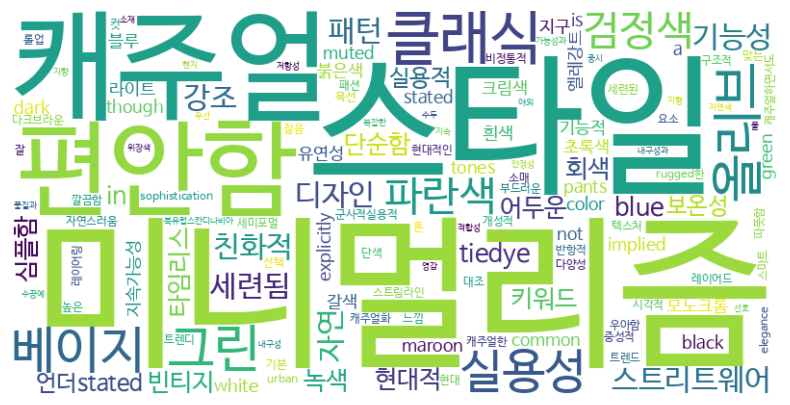

In [28]:
from collections import Counter
from wordcloud import WordCloud
import matplotlib.pyplot as plt

def get_word_count(df):
    ## DataFrame의 'color'와 'keyword' 열에서 단어 빈도를 계산하는 함수
    if not df.empty:
        ## 'color' 열의 모든 단어를 리스트로 합침
        all_nouns = df['color'].apply(str.split).sum()
        ## 'keyword' 열의 모든 단어를 추가
        all_nouns += df['keyword'].apply(str.split).sum()
        ## '색상' 단어를 제외한 모든 단어를 필터링
        all_nouns = [word for word in all_nouns if word not in ['색상']]
        ## 단어 빈도를 Counter 객체로 반환
        return Counter(all_nouns)
    return Counter() ## DataFrame이 비어있으면 빈 Counter 반환

def create_wordcloud(word_count):
    ## 단어 빈도수를 기반으로 워드 클라우드를 생성하고 시각화하는 함수
    if not word_count: ## 단어 빈도가 없으면 워드클라우드 생성하지 않음
        print("No words to generate word cloud.")
        return

    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='white',
        colormap='viridis',
        font_path='/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' ## 한글 폰트 경로 지정
        ).generate_from_frequencies(word_count)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off") ## 축 표시 제거
    plt.show() ## 워드 클라우드 출력

## DataFrame에서 단어 빈도 계산
word_count = get_word_count(df)
## 계산된 단어 빈도로 워드 클라우드 생성 및 시각화
create_wordcloud(word_count)

## 14-14 트렌드 분석 보고서 생성 프롬프트 구성 및 실행

## 14-15 분석 보고서 시각화

In [30]:
from vllm import SamplingParams ## SamplingParams 임포트가 필요

## 시스템 메시지로 시작하는 프롬프트 리스트 초기화
prompt = [
    {
        "role": "system",
        "content": "You are EXAONE model from LG AI Research, a helpful assistant."
    }
]
## DataFrame의 각 행을 순회하며 '스타일 노트'와 '이미지 URL'을 사용자 메시지로 추가
for row in df.itertuples():
  prompt.append({"role": "user", "content": f"스타일 노드 : {row.style}\n 이미지 url : {row.image}"})
## 마지막으로, 종합적인 트렌드 분석 보고서 작성을 요청하는 사용자 메시지 추가
## 보고서 제목, 내용의 전문성, 마크다운 형식, 예시 이미지 포함을 지시
prompt.append({"role": "user", "content": "주어진 스타일의 노트를 토대로 종합적인 트렌드 방향의 분석 보고서를 작성해주세요. 보고서의 제목은 해외 룩북 스타일 분석입니다. 내용은 전문적이면서 멷ㅇ확하게 작성해주세요. 문서 형식은 마크다운입니다. 예시 이미지를 적절한 곳에 추가해서 바로 볼 수 있도록 해주세요"})

## 샘플링 파라미터 설정 (온도, top_p, 최대 토큰 수)
sampling_params = SamplingParams(temperature=0.2, top_p=0.95, max_tokens=4096)
## LLM 모델을 사용하여 구성된 프롬프트에 대한 응답 생성
result = llm.chat(prompt, sampling_params)[0].outputs[0].text

Processed prompts: 100%|██████████| 1/1 [00:30<00:00, 30.36s/it, est. speed input: 107.00 toks/s, output: 37.09 toks/s]


In [31]:
from IPython.display import display, Markdown

## LLM으로부터 생성된 결과(Markdown 형식의 보고서)를 Jupyter 환경에 표시
display(Markdown(result))

# 해외 룩북 스타일 분석 보고서

## 요약
본 보고서는 최근 여러 해외 패션 룩북에서 관찰되는 주요 스타일 트렌드를 종합적으로 분석하고, 이를 통해 현재 패션 산업의 방향성을 제시합니다. 특히 다양한 이미지와 색상 팔레트, 소재 선택 등을 통해 나타나는 변화를 중점적으로 살펴봅니다.

## 트렌드 분석

### 1. **미니멀리즘과 실용성의 융합**
- **예시 이미지**: [Trove Spring-Summer 2026 Collection Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/09/trove-spring-summer-2026-collection-lookbook-10-1024x683.jpg)
  - **분석**: 미니멀리즘과 기능성을 결합한 스타일이 주류를 이루고 있다. 단순한 디자인과 단색 팔레트는 시간을 초월한 우아함을 제공하며, 실용적인 소재와 디자인 요소를 통해 편안함과 스타일을 동시에 추구한다.
  - **트렌드**: 지속 가능성과 미니멀리즘의 결합이 패션 트렌드의 핵심으로 부상하고 있다.

### 2. **자연 친화적 색상 팔레트**
- **예시 이미지**: [Rakines Fall-Winter 2025 Collection Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/10/rakines-fall-winter-2025-collection-lookbook-08-1024x682.jpg)
  - **분석**: 올리브 그린, 베이지, 그레이 등 자연 친화적인 색상이 주를 이루며, 이는 계절적 변화와 피부 톤에 대한 유연성을 제공한다.
  - **트렌드**: 환경 친화적인 소재와 자연스러운 색상 팔레트의 인기가 지속되고 있다.

### 3. **실용성과 스타일의 조화**
- **예시 이미지**: [Trove Spring-Summer 2026 Collection Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/09/trove-spring-summer-2026-collection-lookbook-10-1024x683.jpg)
  - **분석**: 기능적인 요소와 스타일리시한 디자인의 조화가 두드러진다. 예를 들어, 블랙 재킷과 올리브 그린 코트는 실용성과 세련됨을 동시에 제공한다.
  - **트렌드**: 실용적인 기능성과 패션의 융합이 새로운 트렌드로 부상하고 있다.

### 4. **지속 가능성과 윤리적 패션**
- **예시 이미지**: [Bluebluejapan Fall-Winter 2025 Collection Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/09/bluebluejapan-fall-winter-2025-collection-lookbook-11-1024x683.jpg)
  - **분석**: 친환경 소재와 윤리적 제조 과정을 강조하는 디자인이 증가하고 있다. 이는 소비자들의 지속 가능성에 대한 관심 증가와 맞물려 있다.
  - **트렌드**: 패션 산업 내에서 지속 가능성과 윤리적 생산이 중요한 이슈로 부상하고 있다.

### 5. **실용적이고 기능적인 신발 디자인**
- **예시 이미지**: [South2 West8 Suicoke Fall-Winter 2025 Beetle Lo Lookbook](https://glltn.com/wp-content/blogs.dir/1/files/2025/09/south2-west8-suicoke-fall-winter-2025-beetle-lo-01-1024x683.jpg)
  - **분석**: 기능성과 실용성을 강조하는 신발 디자인이 두드러진다. 특히, suede 소재와 깊은 트레드 패턴은 야외 활동에 적합하며, 금속 eyelets는 안정성을 제공한다.
  - **트렌드**: 활동성과 편안함을 동시에 추구하는 신발 디자인이 패션 트렌드의 중요한 부분으로 자리잡고 있다.

## 결론
현재 패션 산업은 미니멀리즘과 실용성의 융합, 자연 친화적인 색상 팔레트, 지속 가능성과 윤리적 패션의 중요성을 강조하는 방향으로 진화하고 있다. 이러한 트렌드는 소비자들의 생활 패턴과 환경 인식 변화에 적극적으로 반응하며, 미래의 패션은 더욱 기능적이고 지속 가능한 방향으로 나아갈 것으로 예상된다.

---

이 보고서는 다양한 패션 룩북 이미지를 바탕으로 작성되었으며, 각 트렌드 요소는 실제 패션 시장의 변화를 반영하고 있습니다. 이러한 분석은 패션 디자이너와 소비자 모두에게 유용한 지침을 제공할 수 있습니다.